# Regressão

In [1]:
%pylab inline

from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from utils import zscore
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor

style.use('material_darker')
figsize(10, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train = pd.read_csv("../DS Challenge/regression_train.csv").dropna()
X_train = zscore(X_train)
X_test = pd.read_csv("../DS Challenge/regression_test.csv").dropna()
X_test = zscore(X_test)

## Visualizando os dados

In [3]:
X_train.describe()

,target,X1,X2,X3,X4,X5,X6,X7
count,7.150000e+02,7.150000e+02,7.150000e+02,7.150000e+02,7.150000e+02,7.150000e+02,7.150000e+02,7.150000e+02
mean,-1.860206e-16,-4.735916e-16,4.083757e-16,1.863932e-15,3.627246e-16,-2.458639e-15,-1.062087e-16,9.459411e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.472739e-01,-2.631164e+00,-1.646589e+00,-2.963771e+00,-9.286025e-01,-5.928362e+00,-1.413612e+00,-1.646589e+00
25%,-7.025528e-01,-6.559233e-01,-7.773913e-01,-6.554121e-01,-6.933586e-01,-4.303168e-01,-1.413612e+00,-7.773913e-01
50%,-3.399231e-01,-4.385672e-03,-1.500242e-01,1.185060e-02,-3.217945e-01,-9.588370e-03,1.309060e-01,-1.500242e-01
75%,3.137168e-01,6.219702e-01,5.890416e-01,6.839979e-01,3.256420e-01,4.062819e-01,1.057617e+00,5.890416e-01
max,5.669422e+00,3.184713e+00,3.517865e+00,3.167524e+00,6.596324e+00,1.248450e+01,1.057617e+00,3.517865e+00


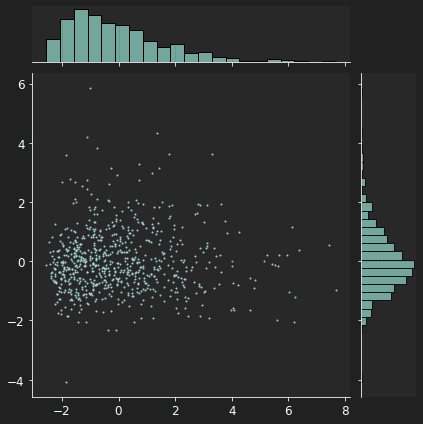

In [4]:
pca = PCA(n_components=2)
trans_data = pca.fit_transform(X_train)
sns.jointplot(x=trans_data[:,0], y=trans_data[:, 1], s=3)

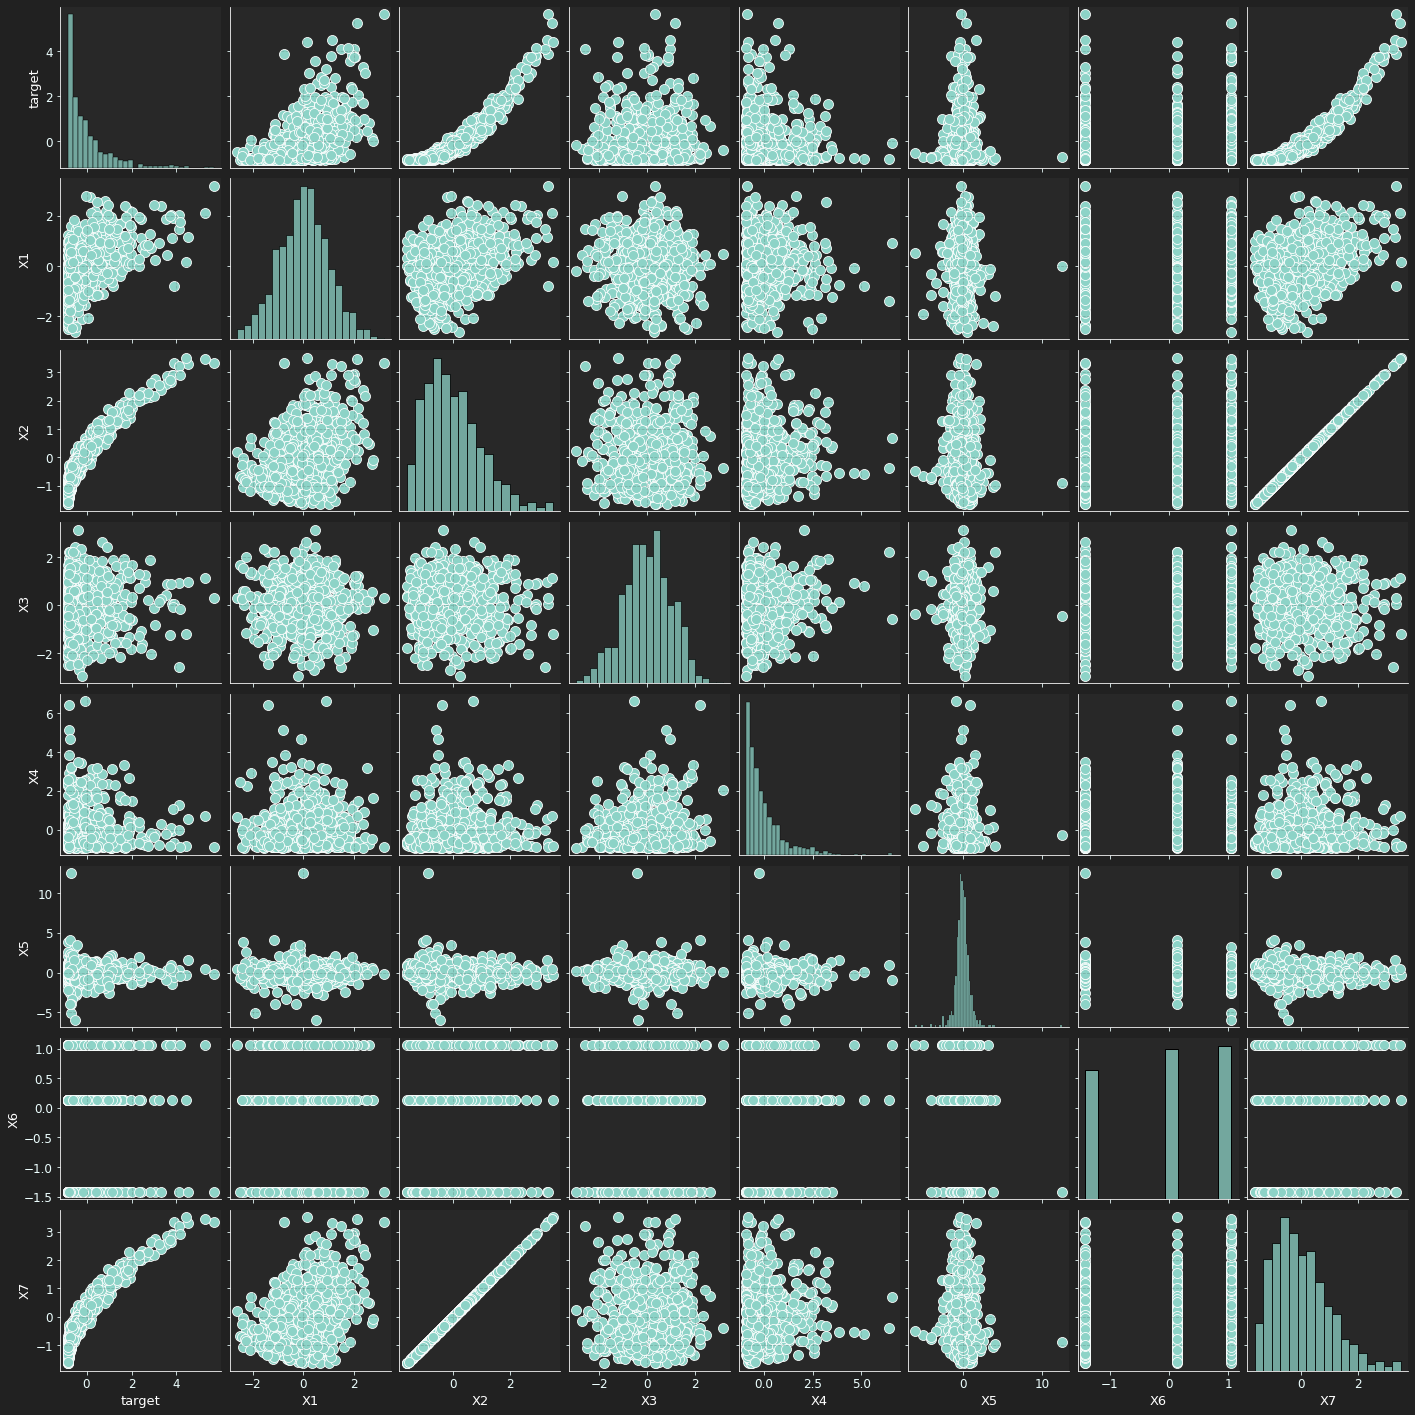

In [5]:
sns.pairplot(X_train)

<AxesSubplot:>

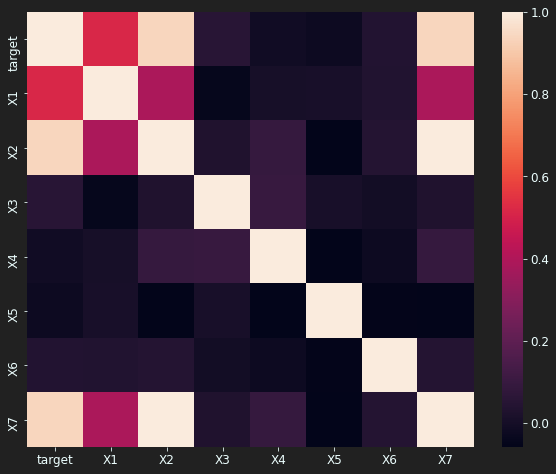

In [6]:
sns.heatmap(X_train.corr())

In [7]:
Y_train = X_train.pop("target")
Y_test = X_test.pop("target")

In [8]:
model = ExtraTreesRegressor(n_estimators=100).fit(X_train.to_numpy(), Y_train)
sfm = SelectFromModel(model, prefit=True)

for col, values in zip(X_train.columns, model.feature_importances_):
    print(f"{col}: {values:.3f}")

X1: 0.026
X2: 0.500
X3: 0.003
X4: 0.006
X5: 0.002
X6: 0.001
X7: 0.463


as features X2 e X7 correspondem a mais de 90% de importância sobre o valor de "target" segundo o `ExtraTreesRegressor`, mas isso confirma o observado nos gráficos anteriores: o heatmap de correlação indica uma forte correlação entre essas mesmas features enquanto no `pairplot` do seaborn revela como essas mesmas features se mostram alinhadas com um formato ideal para uma regressão.

## Definindo os parâmetros do regressor e fazendo o treinamento

In [9]:
X_train = X_train[["X2", "X7"]]
X_test = X_test[["X2", "X7"]]

In [10]:
parameters = {
    "kernel": ["rbf", "poly", "sigmoid"],
    "C": linspace(0.1, 10, 20),
    "gamma": linspace(0.1, 1.5, 20)
}

In [11]:
svr = SVR()
grid =  GridSearchCV(svr, parameters, n_jobs=-1, scoring="r2")
grid.fit(X_train, Y_train)

GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ]),
                         'gamma': array([0.1       , 0.17368421, 0.24736842, 0.32105263, 0.39473684,
       0.46842105, 0.54210526, 0.61578947, 0.68947368, 0.76315789,
       0.83684211, 0.91052632, 0.98421053, 1.05789474, 1.13157895,
       1.20526316, 1.27894737, 1.35263158, 1.42631579, 1.5       ]),
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='r2')

In [12]:
grid.best_params_

{'C': 4.268421052631579, 'gamma': 0.1, 'kernel': 'rbf'}

In [13]:
svr = SVR(**grid.best_params_)
svr.fit(X_train, Y_train)

SVR(C=4.268421052631579, gamma=0.1)

## Avaliando os resultados

In [14]:
result = svr.predict(X_test)

In [28]:
{
    "variance": metrics.explained_variance_score(Y_test, result),
    "mean absolute error": metrics.mean_squared_error(Y_test, result, squared=False),
    "R2": metrics.r2_score(Y_test, result)
}

{'variance': 0.9554397483739537,
 'mean absolute error': 0.210601465600183,
 'R2': 0.9553992406908932}

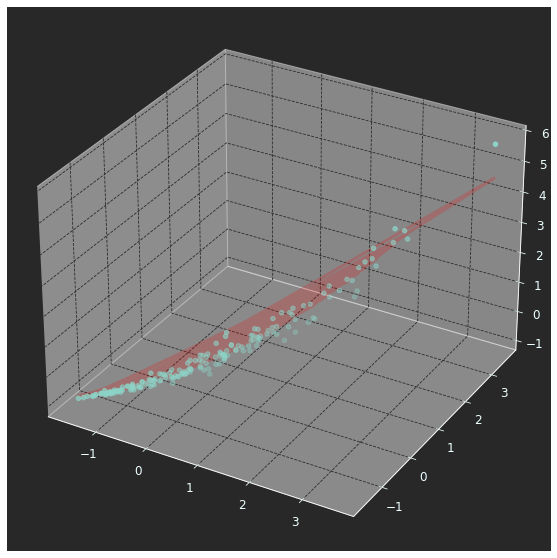

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=X_test.X2, ys=X_test.X7, zs=Y_test)
ax.plot(xs=X_test.X2, ys=X_test.X7, zs=result, c="red", alpha=0.2)